<a href="https://colab.research.google.com/github/visshal2301/AdvanceSpark_GoogleColab/blob/main/2_ReadQueryDagSpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [ ]:
!pip install -q pyngrok

In [ ]:
spark = SparkSession.builder \
       .master("local[*]") \
       .appName("Colab") \
       .config('spark.ui.port', '4050') \
       .getOrCreate()
spark

Transaction Data

In [ ]:
# prompt: need to see spark UI using colab
from pyngrok import ngrok
from google.colab import userdata

# Get the ngrok authtoken from Colab secrets
# You need to add your ngrok authtoken to Colab's secrets with the name 'NGROK_AUTH_TOKEN'
ngrok_auth_token = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_auth_token)

public_url = ngrok.connect(4050).public_url
print(f"Spark UI: {public_url}")

Spark UI: https://858465320c3f.ngrok-free.app


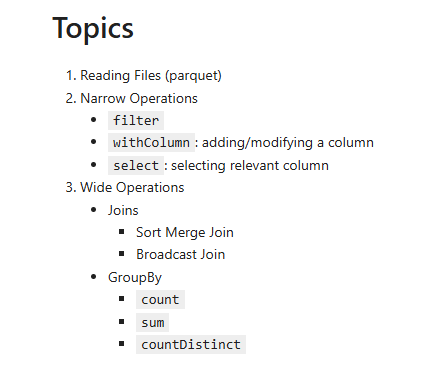

In [ ]:
transactions_file = "/content/drive/MyDrive/data/data_skew/transactions.parquet"
df_transactions = spark.read.parquet(transactions_file)
df_transactions.show()
df_transactions.rdd.getNumPartitions()

+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+------------+
|   cust_id|start_date|  end_date|         txn_id|      date|year|month|day| expense_type|   amt|        city|
+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+------------+
|C0YDPQWPBJ|2010-07-01|2018-12-01|TZ5SMKZY9S03OQJ|2018-10-07|2018|   10|  7|Entertainment| 10.42|      boston|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYIAPPNU066CJ5R|2016-03-27|2016|    3| 27| Motor/Travel| 44.34|    portland|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TETSXIK4BLXHJ6W|2011-04-11|2011|    4| 11|Entertainment|  3.18|     chicago|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TQKL1QFJY3EM8LO|2018-02-22|2018|    2| 22|    Groceries|268.97| los_angeles|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYL6DFP09PPXMVB|2010-10-16|2010|   10| 16|Entertainment|  2.66|     chicago|
|C0YDPQWPBJ|2010-07-01|2018-12-01|T1SMX9EUG21BBSE|2015-02-11|2015|    2| 11|    Education| 54.14|    portland|
|

12

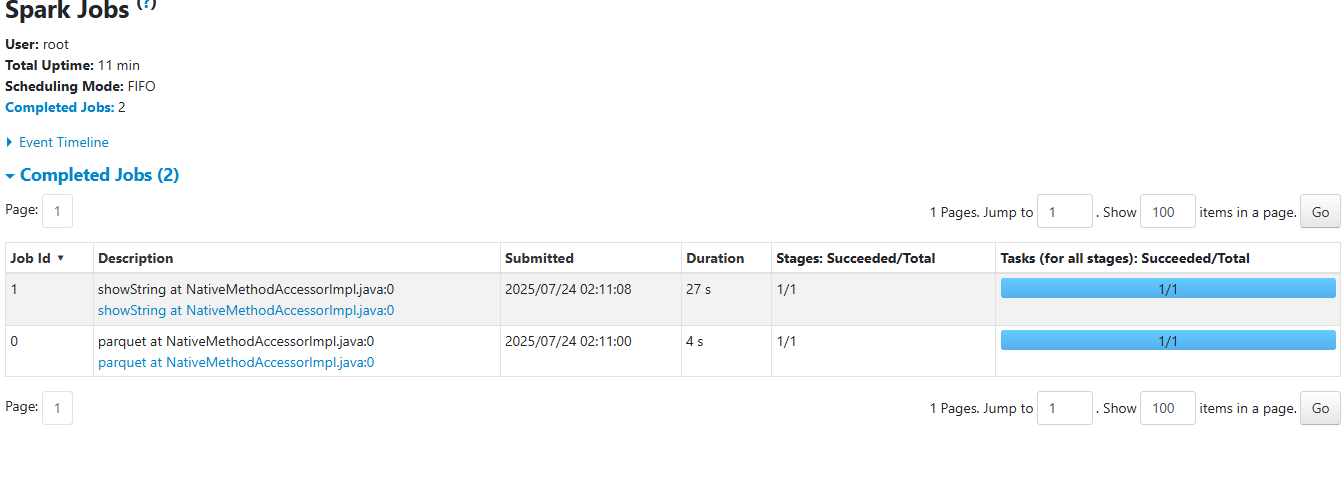

Two Jobs Are Created :- The 0th file is to read the meta data.



In [ ]:
customers_file = "/content/drive/MyDrive/data/data_skew/customers.parquet"
df_customers = spark.read.parquet(customers_file)
df_customers.show()
df_customers.rdd.getNumPartitions()


+----------+--------------+---+------+----------+-----+------------+
|   cust_id|          name|age|gender|  birthday|  zip|        city|
+----------+--------------+---+------+----------+-----+------------+
|C007YEYTX9|  Aaron Abbott| 34|Female| 7/13/1991|97823|      boston|
|C00B971T1J|  Aaron Austin| 37|Female|12/16/2004|30332|     chicago|
|C00WRSJF1Q|  Aaron Barnes| 29|Female| 3/11/1977|23451|      denver|
|C01AZWQMF3| Aaron Barrett| 31|  Male|  7/9/1998|46613| los_angeles|
|C01BKUFRHA|  Aaron Becker| 54|  Male|11/24/1979|40284|   san_diego|
|C01RGUNJV9|    Aaron Bell| 24|Female| 8/16/1968|86331|      denver|
|C01USDV4EE|   Aaron Blair| 35|Female|  9/9/1974|80078|    new_york|
|C01WMZQ7PN|   Aaron Brady| 51|Female| 8/20/1994|52204|philadelphia|
|C021567NJZ|  Aaron Briggs| 57|  Male| 3/10/1990|22008|philadelphia|
|C023M6MKR3|   Aaron Bryan| 29|  Male| 4/10/1976|05915|philadelphia|
|C0248N0EK3|  Aaron Burton| 26|Female| 8/27/1964|50477| los_angeles|
|C02C54RPNL|  Aaron Burton| 46|  M

1

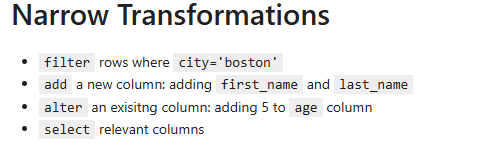

In [ ]:
df_narrow_transform = (
    df_customers
    .filter(F.col("city") == "boston")
    .withColumn("first_name", F.split("name", " ").getItem(0))
    .withColumn("last_name", F.split("name", " ").getItem(1))
    .withColumn("age", F.col("age") + F.lit(5))
    .select("cust_id", "first_name", "last_name", "age", "gender", "birthday")
)

df_narrow_transform.write.format("noop").mode("overwrite").save("../data/test/df_narrow_transform.parquet")

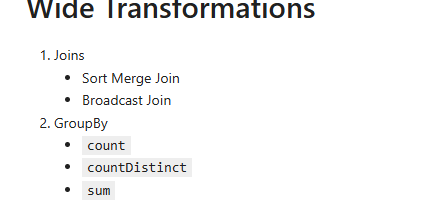

**Sort Merge Join**

In [ ]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [ ]:
df_joined = (
    df_transactions.join(
        df_customers,
        how="inner",
        on="cust_id"
    )
)

In [ ]:
df_joined.write.format("noop").mode("overwrite").save("../data/test/df_joined.parquet")

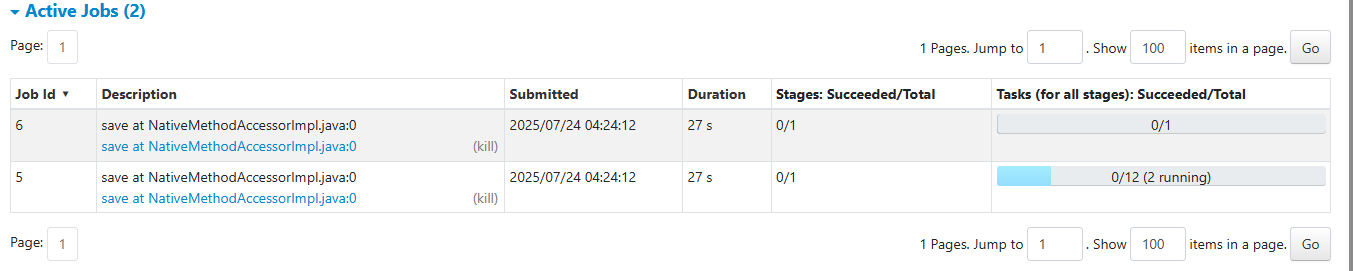

The Join is happening with Customer and transaction data set . 2 Jobs has been created . One Job For reading data and do the join operation . and the other job is for write. One thing to notice since join is a wide transformation thus multiple stages has been created.

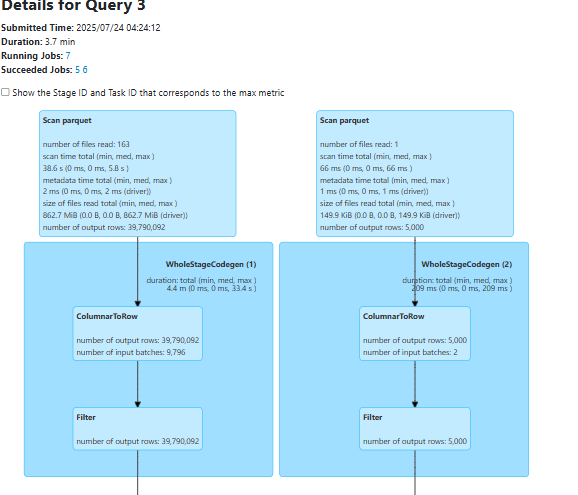


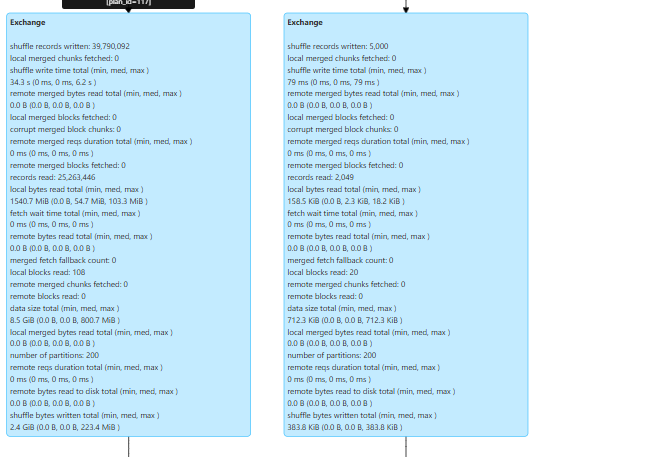

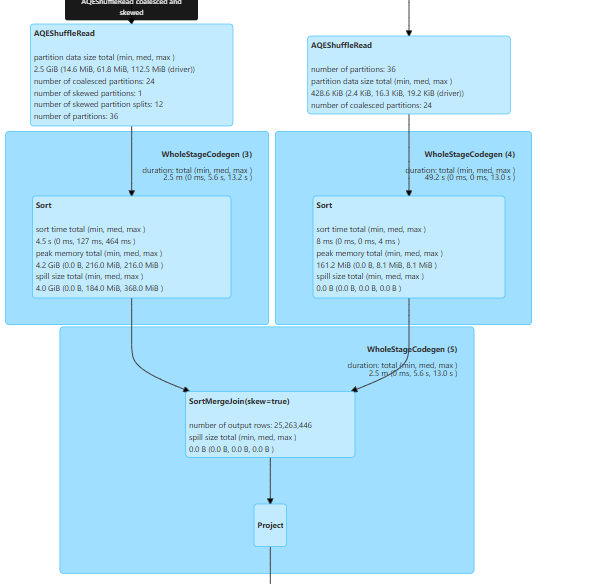

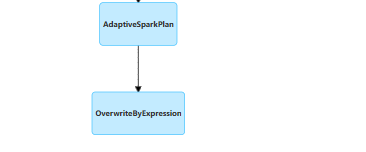

The stage for JOB 2

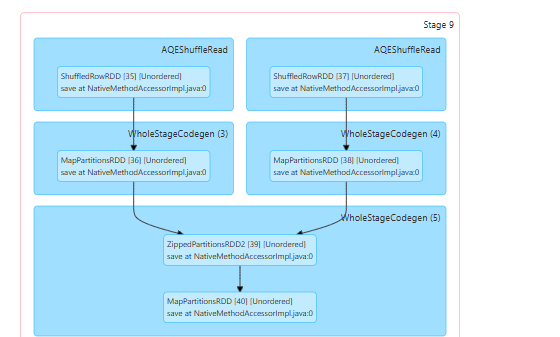

Broadcast Join

In [ ]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 10485760)

In [ ]:
df_broadcast_joined = (
    df_transactions.join(
        F.broadcast(df_customers),
        how="inner",
        on="cust_id"
    )
)

In [ ]:
df_broadcast_joined.write.format("noop").mode("overwrite").save("../data/test/df_broadcast_joined.parquet")

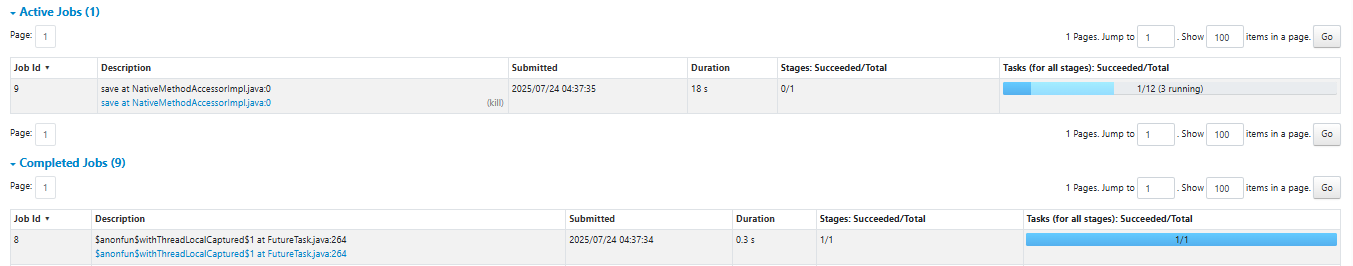

Job 8 And 9 Initiated

Job8 :-
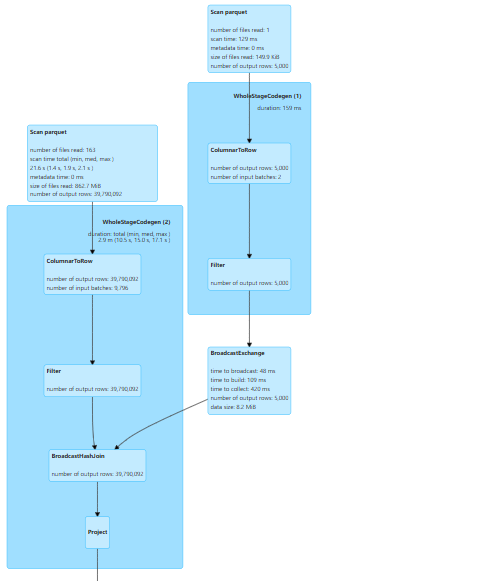
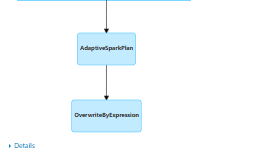

**3.Group By **

In [ ]:
df_city_counts = (
    df_transactions
    .groupBy("city")
    .count()
)
df_city_counts.show(5, False)

+---------+-------+
|city     |count  |
+---------+-------+
|san_diego|3977780|
|chicago  |3979023|
|denver   |3980274|
|boston   |3978268|
|seattle  |3980022|
+---------+-------+
only showing top 5 rows



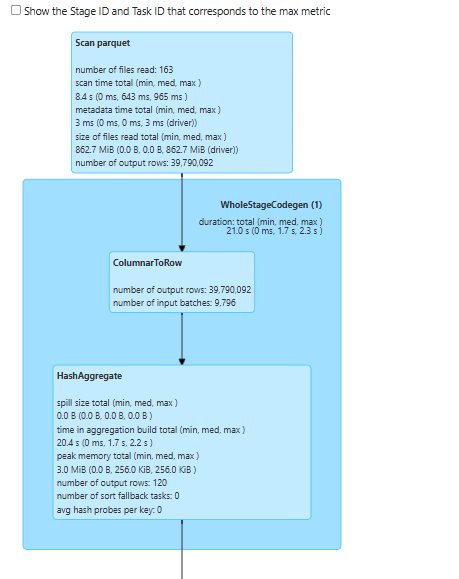

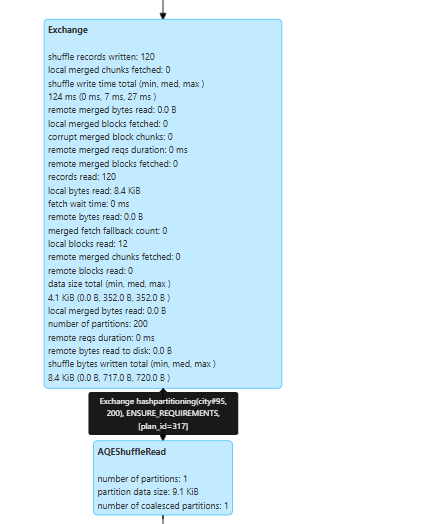

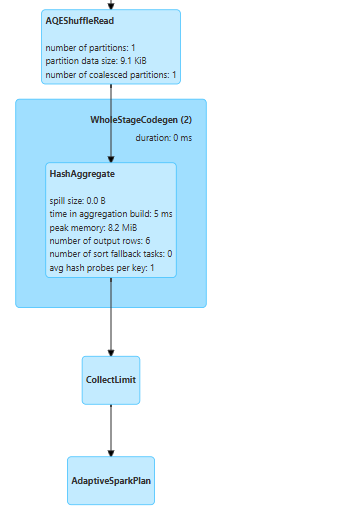

In [ ]:
df_txn_amt_city = (
    df_transactions
    .groupBy("city")
    .agg(F.sum("amt").alias("txn_amt"))
)

In [ ]:
df_txn_amt_city.show(5, False)

+---------+--------------------+
|city     |txn_amt             |
+---------+--------------------+
|san_diego|3.297982686000007E8 |
|chicago  |3.2988120044000095E8|
|denver   |3.298814956400023E8 |
|boston   |3.301009563300014E8 |
|seattle  |3.3019513776999813E8|
+---------+--------------------+
only showing top 5 rows



**GroupBy Count Distinct**

In [ ]:
df_txn_per_city = (
    df_transactions
    .groupBy("city")
    .agg(F.countDistinct("txn_id").alias("txn_count"))
)

In [ ]:
df_txn_per_city.show(5, False)

+---------+---------+
|city     |txn_count|
+---------+---------+
|san_diego|3977780  |
|chicago  |3979023  |
|denver   |3980274  |
|boston   |3978268  |
|seattle  |3980022  |
+---------+---------+
only showing top 5 rows



In [ ]:
spark.stop()

NameError: name 'spark' is not defined